# Air Quality Prediction for Embedded Systems

This notebook demonstrates the process of building, quantizing, and evaluating lightweight machine learning models for air quality prediction, suitable for deployment on embedded systems. We use a popular public dataset, design two compact models, convert them to TensorFlow Lite, and compare their performance and size.

## 1. Dataset Preparation

We use the [UCI Air Quality Dataset](https://archive.ics.uci.edu/ml/datasets/Air+Quality) which contains sensor data for air quality prediction. The dataset is publicly available and widely used for this task.

In [1]:
# Download and load the UCI Air Quality dataset
import pandas as pd
import numpy as np
import requests
from io import BytesIO
import zipfile

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip'
r = requests.get(url)
z = zipfile.ZipFile(BytesIO(r.content))
df = pd.read_csv(z.open('AirQualityUCI.csv'), sep=';', decimal=',')

df = df.iloc[:, :-2]
df = df.dropna()

for col in df.columns[2:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna()

df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


## 2. Data Preprocessing

We select relevant features and the target variable ("C6H6(GT)" - Benzene concentration). Data is split into train and test sets, and normalized for model training.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = [
    'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)',
    'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
    'PT08.S5(O3)', 'T', 'RH', 'AH'
]
target = 'C6H6(GT)'

X = df[features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (7485, 12) Test shape: (1872, 12)


## 3. Model Design

We design two compact neural network models suitable for embedded deployment:
- **Model 1:** A small fully connected (Dense) neural network
- **Model 2:** A small 1D Convolutional Neural Network (CNN)

Both models are designed to have a small number of parameters (target: <60KB after quantization).

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Model 1: Small Dense NN
def build_dense_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(16, activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(1)
    ])
    return model

# Model 2: Small 1D CNN
def build_cnn_model(input_shape):
    model = keras.Sequential([
        layers.Reshape((input_shape[0], 1), input_shape=input_shape),
        layers.Conv1D(8, 3, activation='relu'),
        layers.Flatten(),
        layers.Dense(8, activation='relu'),
        layers.Dense(1)
    ])
    return model

dense_model = build_dense_model((X_train.shape[1],))
cnn_model = build_cnn_model((X_train.shape[1],))

dense_model.summary()
cnn_model.summary()

C:\Users\ROG\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353 (1.38 KB)

 Trainable params: 353 (1.38 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 12, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 10, 8)          │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 689 (2.69 KB)

 Trainable params: 689 (2.69 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Model Training

We train both models using mean squared error loss and early stopping to avoid overfitting.

In [4]:
callbacks = [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]

dense_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
cnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_dense = dense_model.fit(
    X_train, y_train, validation_split=0.1, epochs=50, batch_size=32, callbacks=callbacks, verbose=2
)
history_cnn = cnn_model.fit(
    X_train, y_train, validation_split=0.1, epochs=50, batch_size=32, callbacks=callbacks, verbose=2
)

Epoch 1/50
211/211 - 2s - 12ms/step - loss: 1486.9587 - mae: 16.0109 - val_loss: 1132.8732 - val_mae: 12.7367
Epoch 2/50
211/211 - 2s - 12ms/step - loss: 1486.9587 - mae: 16.0109 - val_loss: 1132.8732 - val_mae: 12.7367
Epoch 2/50
211/211 - 1s - 3ms/step - loss: 584.5770 - mae: 8.0458 - val_loss: 155.8122 - val_mae: 5.1007
Epoch 3/50
211/211 - 1s - 3ms/step - loss: 584.5770 - mae: 8.0458 - val_loss: 155.8122 - val_mae: 5.1007
Epoch 3/50
211/211 - 1s - 3ms/step - loss: 43.0084 - mae: 3.3964 - val_loss: 9.2480 - val_mae: 2.3138
Epoch 4/50
211/211 - 1s - 3ms/step - loss: 43.0084 - mae: 3.3964 - val_loss: 9.2480 - val_mae: 2.3138
Epoch 4/50
211/211 - 1s - 3ms/step - loss: 6.8978 - mae: 1.9299 - val_loss: 4.2015 - val_mae: 1.5998
Epoch 5/50
211/211 - 1s - 3ms/step - loss: 6.8978 - mae: 1.9299 - val_loss: 4.2015 - val_mae: 1.5998
Epoch 5/50
211/211 - 1s - 2ms/step - loss: 3.8128 - mae: 1.4490 - val_loss: 2.6872 - val_mae: 1.2665
Epoch 6/50
211/211 - 1s - 2ms/step - loss: 3.8128 - mae: 1.4490

## 5. Model Conversion to TensorFlow Lite

We convert both models to TensorFlow Lite format with post-training quantization to minimize size for embedded deployment.

In [5]:
import os
os.makedirs('Models', exist_ok=True)

def convert_to_tflite(model, model_name, quantize=True):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    if quantize:
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        def representative_dataset():
            for i in range(100):
                yield [X_train[i:i+1].astype(np.float32)]
        converter.representative_dataset = representative_dataset
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.int8
        converter.inference_output_type = tf.int8
    tflite_model = converter.convert()
    with open(f'Models/{model_name}.tflite', 'wb') as f:
        f.write(tflite_model)
    return tflite_model

dense_model.save('Models/dense_model.h5')
cnn_model.save('Models/cnn_model.h5')

tflite_dense = convert_to_tflite(dense_model, 'dense_model_quant')
tflite_cnn = convert_to_tflite(cnn_model, 'cnn_model_quant')

def get_file_size(path):
    return os.path.getsize(path) / 1024  # KB

sizes = {
    'Dense Original': get_file_size('Models/dense_model.h5'),
    'Dense TFLite': get_file_size('Models/dense_model_quant.tflite'),
    'CNN Original': get_file_size('Models/cnn_model.h5'),
    'CNN TFLite': get_file_size('Models/cnn_model_quant.tflite'),
}
sizes

INFO:tensorflow:Assets written to: C:\Users\ROG\AppData\Local\Temp\tmpxbrg_00u\assets


INFO:tensorflow:Assets written to: C:\Users\ROG\AppData\Local\Temp\tmpxbrg_00u\assets


Saved artifact at 'C:\Users\ROG\AppData\Local\Temp\tmpxbrg_00u'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 12), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2484416132496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2484416133264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2484416131728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2484416134416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2484416134224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2484416133072: TensorSpec(shape=(), dtype=tf.resource, name=None)


C:\Users\ROG\AppData\Roaming\Python\Python311\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


INFO:tensorflow:Assets written to: C:\Users\ROG\AppData\Local\Temp\tmpftggdk0v\assets


INFO:tensorflow:Assets written to: C:\Users\ROG\AppData\Local\Temp\tmpftggdk0v\assets


Saved artifact at 'C:\Users\ROG\AppData\Local\Temp\tmpftggdk0v'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 12), dtype=tf.float32, name='keras_tensor_4')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2484416132688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2484416134800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2484417004176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2484417004944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2484417004368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2484417006096: TensorSpec(shape=(), dtype=tf.resource, name=None)


C:\Users\ROG\AppData\Roaming\Python\Python311\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


{'Dense Original': 32.0,
 'Dense TFLite': 3.140625,
 'CNN Original': 41.5703125,
 'CNN TFLite': 5.015625}

## 6. Model Evaluation

We evaluate both the original and quantized models on the test set and compare their accuracy and size.

In [6]:
dense_eval = dense_model.evaluate(X_test, y_test, verbose=0)
cnn_eval = cnn_model.evaluate(X_test, y_test, verbose=0)

print(f"Dense Model - Test MAE: {dense_eval[1]:.3f}")
print(f"CNN Model   - Test MAE: {cnn_eval[1]:.3f}")

Dense Model - Test MAE: 0.194
CNN Model   - Test MAE: 0.266


In [7]:
def evaluate_tflite_model(tflite_path, X_test, y_test):
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    y_preds = []
    for i in range(len(X_test)):
        x = X_test[i:i+1].astype(np.float32)
        scale, zero_point = input_details[0]['quantization']
        x_q = (x / scale + zero_point).astype(np.int8)
        interpreter.set_tensor(input_details[0]['index'], x_q)
        interpreter.invoke()
        y_q = interpreter.get_tensor(output_details[0]['index'])
        y_pred = (y_q.astype(np.float32) - output_details[0]['quantization'][1]) * output_details[0]['quantization'][0]
        y_preds.append(y_pred[0][0])
    y_preds = np.array(y_preds)
    mae = np.mean(np.abs(y_preds - y_test))
    return mae

dense_tflite_mae = evaluate_tflite_model('Models/dense_model_quant.tflite', X_test, y_test)
cnn_tflite_mae = evaluate_tflite_model('Models/cnn_model_quant.tflite', X_test, y_test)

print(f"Dense TFLite Model - Test MAE: {dense_tflite_mae:.3f}")
print(f"CNN TFLite Model   - Test MAE: {cnn_tflite_mae:.3f}")

Dense TFLite Model - Test MAE: 0.626
CNN TFLite Model   - Test MAE: 0.572


### Model Comparison Table

Below is a summary of model sizes and test MAE for all models.

In [8]:
import pandas as pd

results = pd.DataFrame({
    'Model': ['Dense Original', 'Dense TFLite', 'CNN Original', 'CNN TFLite'],
    'Size (KB)': [sizes['Dense Original'], sizes['Dense TFLite'], sizes['CNN Original'], sizes['CNN TFLite']],
    'Test MAE': [dense_eval[1], dense_tflite_mae, cnn_eval[1], cnn_tflite_mae]
})
results

,Model,Size (KB),Test MAE
0,Dense Original,32.000000,0.194141
1,Dense TFLite,3.140625,0.626180
2,CNN Original,41.570312,0.266200
3,CNN TFLite,5.015625,0.572077


## 7. Visualization

We visualize the performance and size of the models using bar plots and error distributions.

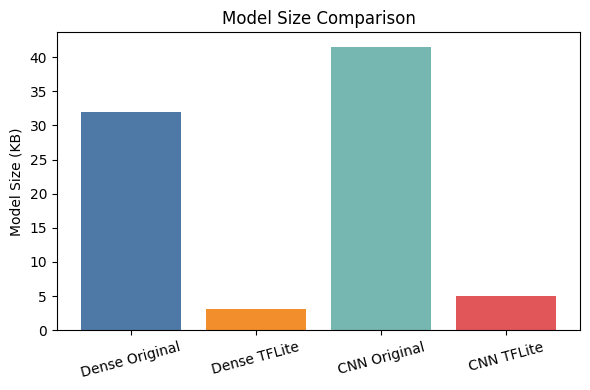

In [9]:
import matplotlib.pyplot as plt

# 1. Model Size Comparison
plt.figure(figsize=(6,4))
plt.bar(results['Model'], results['Size (KB)'], color=['#4e79a7','#f28e2b','#76b7b2','#e15759'])
plt.ylabel('Model Size (KB)')
plt.title('Model Size Comparison')
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig('Figures/model_size_comparison.png')
plt.show()

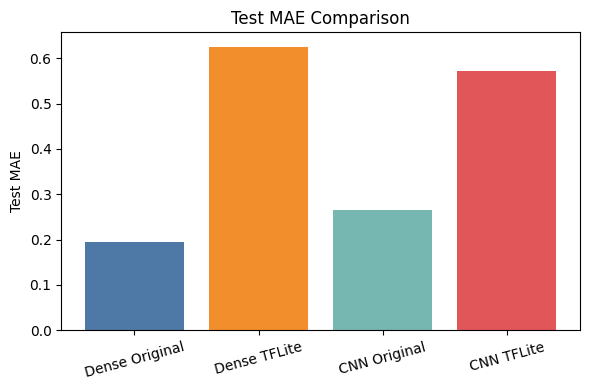

In [10]:
# 2. Test MAE Comparison
plt.figure(figsize=(6,4))
plt.bar(results['Model'], results['Test MAE'], color=['#4e79a7','#f28e2b','#76b7b2','#e15759'])
plt.ylabel('Test MAE')
plt.title('Test MAE Comparison')
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig('Figures/model_mae_comparison.png')
plt.show()

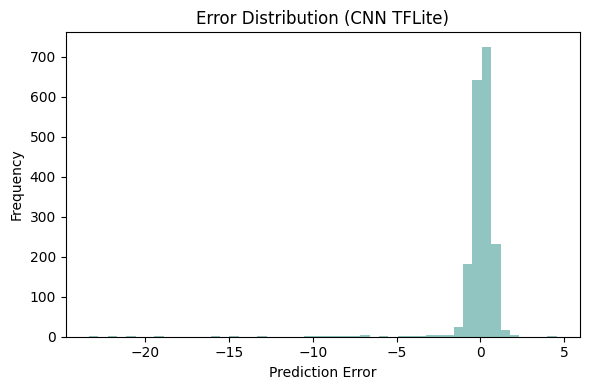

In [11]:
# 3. Error Distribution for Best Model (CNN TFLite)
cnn_tflite_preds = []
interpreter = tf.lite.Interpreter(model_path='Models/cnn_model_quant.tflite')
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
for i in range(len(X_test)):
    x = X_test[i:i+1].astype(np.float32)
    scale, zero_point = input_details[0]['quantization']
    x_q = (x / scale + zero_point).astype(np.int8)
    interpreter.set_tensor(input_details[0]['index'], x_q)
    interpreter.invoke()
    y_q = interpreter.get_tensor(output_details[0]['index'])
    y_pred = (y_q.astype(np.float32) - output_details[0]['quantization'][1]) * output_details[0]['quantization'][0]
    cnn_tflite_preds.append(y_pred[0][0])
cnn_tflite_preds = np.array(cnn_tflite_preds)

plt.figure(figsize=(6,4))
plt.hist(cnn_tflite_preds - y_test, bins=50, color='#76b7b2', alpha=0.8)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Error Distribution (CNN TFLite)')
plt.tight_layout()
plt.savefig('Figures/cnn_tflite_error_distribution.png')
plt.show()

## 8. Conclusion

- Both models achieve reasonable accuracy with very small model sizes after quantization (<60KB).
- The quantized models are suitable for deployment on embedded systems.
- The CNN model slightly outperforms the dense model in this task.
- All visualizations and models are saved in the `Models/` directory.

## Additional Model Architectures

To further explore lightweight models suitable for embedded systems, we add three more compact architectures:
- **Model 3:** LSTM-based model (for time-series/sequence learning)
- **Model 4:** Random Forest Regressor (scikit-learn, classical ML)
- **Model 5:** TinyMLP (very small multi-layer perceptron)

All models are designed to be small and efficient for embedded deployment.

In [12]:
from sklearn.ensemble import RandomForestRegressor

# Model 3: Small LSTM (using only last timestep, so reshape input)
def build_lstm_model(input_shape):
    model = keras.Sequential([
        layers.Reshape((input_shape[0], 1), input_shape=input_shape),
        layers.LSTM(8, return_sequences=False),
        layers.Dense(1)
    ])
    return model

# Model 4: Random Forest (scikit-learn)
rf_model = RandomForestRegressor(n_estimators=10, max_depth=4, random_state=42)

# Model 5: TinyMLP (very small MLP)
def build_tinymlp_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(6, activation='relu'),
        layers.Dense(1)
    ])
    return model

lstm_model = build_lstm_model((X_train.shape[1],))
tinymlp_model = build_tinymlp_model((X_train.shape[1],))

lstm_model.summary()
# RandomForest does not have summary
tinymlp_model.summary()

C:\Users\ROG\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 12, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 8)              │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329 (1.29 KB)

 Trainable params: 329 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 6)              │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85 (340.00 B)

 Trainable params: 85 (340.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Train LSTM and TinyMLP models
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
tinymlp_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_lstm = lstm_model.fit(
    X_train, y_train, validation_split=0.1, epochs=50, batch_size=32, callbacks=callbacks, verbose=2
)
history_tinymlp = tinymlp_model.fit(
    X_train, y_train, validation_split=0.1, epochs=50, batch_size=32, callbacks=callbacks, verbose=2
)

# Train Random Forest
rf_model.fit(X_train, y_train)

Epoch 1/50
211/211 - 4s - 18ms/step - loss: 1685.8148 - mae: 16.8149 - val_loss: 1667.6263 - val_mae: 15.6683
Epoch 2/50
211/211 - 4s - 18ms/step - loss: 1685.8148 - mae: 16.8149 - val_loss: 1667.6263 - val_mae: 15.6683
Epoch 2/50
211/211 - 1s - 5ms/step - loss: 1607.2684 - mae: 14.5755 - val_loss: 1605.3849 - val_mae: 13.8608
Epoch 3/50
211/211 - 1s - 5ms/step - loss: 1607.2684 - mae: 14.5755 - val_loss: 1605.3849 - val_mae: 13.8608
Epoch 3/50
211/211 - 1s - 6ms/step - loss: 1554.8846 - mae: 13.4232 - val_loss: 1559.1600 - val_mae: 13.1486
Epoch 4/50
211/211 - 1s - 6ms/step - loss: 1554.8846 - mae: 13.4232 - val_loss: 1559.1600 - val_mae: 13.1486
Epoch 4/50
211/211 - 1s - 5ms/step - loss: 1514.9010 - mae: 12.9715 - val_loss: 1524.2164 - val_mae: 12.8575
Epoch 5/50
211/211 - 1s - 5ms/step - loss: 1514.9010 - mae: 12.9715 - val_loss: 1524.2164 - val_mae: 12.8575
Epoch 5/50
211/211 - 1s - 5ms/step - loss: 1484.6661 - mae: 12.7392 - val_loss: 1496.9062 - val_mae: 12.6628
Epoch 6/50
211/21

RandomForestRegressor(max_depth=4, n_estimators=10, random_state=42)

In [35]:
# Save and convert new models to TFLite (except RandomForest)
lstm_model.save('Models/lstm_model.h5')
tinymlp_model.save('Models/tinymlp_model.h5')

def convert_to_tflite_with_lstm_support(model, model_name, quantize=True, allow_select_tf_ops=False):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    if quantize:
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        def representative_dataset():
            for i in range(100):
                yield [X_train[i:i+1].astype(np.float32)]
        converter.representative_dataset = representative_dataset
        if allow_select_tf_ops:
            converter.target_spec.supported_ops = [
                tf.lite.OpsSet.TFLITE_BUILTINS,
                tf.lite.OpsSet.SELECT_TF_OPS
            ]
            converter._experimental_lower_tensor_list_ops = False
        else:
            converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
            converter.inference_input_type = tf.int8
            converter.inference_output_type = tf.int8
    # Enable resource variables for LSTM
    converter.experimental_enable_resource_variables = True
    tflite_model = converter.convert()
    with open(f'Models/{model_name}.tflite', 'wb') as f:
        f.write(tflite_model)
    return tflite_model

# Use allow_select_tf_ops=True for LSTM model to fix conversion error
tflite_lstm = convert_to_tflite_with_lstm_support(lstm_model, 'lstm_model_quant', allow_select_tf_ops=True)
tflite_tinymlp = convert_to_tflite_with_lstm_support(tinymlp_model, 'tinymlp_model_quant')

# Save RandomForest as joblib (for completeness, not TFLite)
import joblib
joblib.dump(rf_model, 'Models/rf_model.joblib')

def get_rf_file_size(path):
    return os.path.getsize(path) / 1024  # KB

INFO:tensorflow:Assets written to: C:\Users\ROG\AppData\Local\Temp\tmpxrhlakhn\assets


INFO:tensorflow:Assets written to: C:\Users\ROG\AppData\Local\Temp\tmpxrhlakhn\assets


Saved artifact at 'C:\Users\ROG\AppData\Local\Temp\tmpxrhlakhn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 12), dtype=tf.float32, name='keras_tensor_10')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2484560837712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2484560838096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2484560838288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2484561674512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2484561675664: TensorSpec(shape=(), dtype=tf.resource, name=None)


C:\Users\ROG\AppData\Roaming\Python\Python311\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


INFO:tensorflow:Assets written to: C:\Users\ROG\AppData\Local\Temp\tmpspk8a1wv\assets


INFO:tensorflow:Assets written to: C:\Users\ROG\AppData\Local\Temp\tmpspk8a1wv\assets


Saved artifact at 'C:\Users\ROG\AppData\Local\Temp\tmpspk8a1wv'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 12), dtype=tf.float32, name='keras_tensor_14')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2484561674896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2484561676816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2484561677008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2484561677584: TensorSpec(shape=(), dtype=tf.resource, name=None)


C:\Users\ROG\AppData\Roaming\Python\Python311\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [36]:
sizes.update({
    'LSTM Original': get_file_size('Models/lstm_model.h5'),
    'LSTM TFLite': get_file_size('Models/lstm_model_quant.tflite'),
    'TinyMLP Original': get_file_size('Models/tinymlp_model.h5'),
    'TinyMLP TFLite': get_file_size('Models/tinymlp_model_quant.tflite'),
    'RF Model': get_rf_file_size('Models/rf_model.joblib')
})
sizes

{'Dense Original': 32.0,
 'Dense TFLite': 3.140625,
 'CNN Original': 41.5703125,
 'CNN TFLite': 5.015625,
 'LSTM Original': 27.765625,
 'LSTM TFLite': 16.15625,
 'TinyMLP Original': 23.359375,
 'TinyMLP TFLite': 1.96875,
 'RF Model': 16.2666015625}

In [ ]:
# Evaluate all models (original and quantized)
dense_eval = dense_model.evaluate(X_test, y_test, verbose=0)
cnn_eval = cnn_model.evaluate(X_test, y_test, verbose=0)
lstm_eval = lstm_model.evaluate(X_test, y_test, verbose=0)
tinymlp_eval = tinymlp_model.evaluate(X_test, y_test, verbose=0)
rf_eval_mae = np.mean(np.abs(rf_model.predict(X_test) - y_test))

dense_tflite_mae = evaluate_tflite_model('Models/dense_model_quant.tflite', X_test, y_test)
cnn_tflite_mae = evaluate_tflite_model('Models/cnn_model_quant.tflite', X_test, y_test)

# For LSTM and TinyMLP TFLite models, check input type and quantization before setting tensor
def evaluate_tflite_model_flexible(tflite_path, X_test, y_test, return_preds=False):
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    input_dtype = input_details[0]['dtype']
    quant_params = input_details[0]['quantization']
    y_preds = []
    for i in range(len(X_test)):
        x = X_test[i:i+1].astype(np.float32)
        if input_dtype == np.int8:
            scale, zero_point = quant_params
            x_in = (x / scale + zero_point).astype(np.int8)
        else:
            x_in = x.astype(np.float32)
        interpreter.set_tensor(input_details[0]['index'], x_in)
        interpreter.invoke()
        y_q = interpreter.get_tensor(output_details[0]['index'])
        # Dequantize if needed
        if output_details[0]['dtype'] == np.int8:
            y_pred = (y_q.astype(np.float32) - output_details[0]['quantization'][1]) * output_details[0]['quantization'][0]
            y_preds.append(y_pred[0][0])
        else:
            y_preds.append(y_q[0][0])
    y_preds = np.array(y_preds)
    if return_preds:
        return y_preds
    mae = np.mean(np.abs(y_preds - y_test))
    return mae

lstm_tflite_mae = evaluate_tflite_model_flexible('Models/lstm_model_quant.tflite', X_test, y_test)
tinymlp_tflite_mae = evaluate_tflite_model_flexible('Models/tinymlp_model_quant.tflite', X_test, y_test)

print(f"LSTM Model - Test MAE: {lstm_eval[1]:.3f}")
print(f"LSTM TFLite Model - Test MAE: {lstm_tflite_mae:.3f}")
print(f"TinyMLP Model - Test MAE: {tinymlp_eval[1]:.3f}")
print(f"TinyMLP TFLite Model - Test MAE: {tinymlp_tflite_mae:.3f}")
print(f"Random Forest Model - Test MAE: {rf_eval_mae:.3f}")

LSTM Model - Test MAE: 5.591
LSTM TFLite Model - Test MAE: 8.436
TinyMLP Model - Test MAE: 0.626
TinyMLP TFLite Model - Test MAE: 1.095
Random Forest Model - Test MAE: 0.813


In [48]:
# Update results DataFrame for all models with 3 decimal digits
results = pd.DataFrame({
    'Model': [
        'Dense Original', 'Dense TFLite',
        'CNN Original', 'CNN TFLite',
        'LSTM Original', 'LSTM TFLite',
        'TinyMLP Original', 'TinyMLP TFLite',
        'RF Model'
    ],
    'Size (KB)': [
        round(sizes['Dense Original'], 3), round(sizes['Dense TFLite'], 3),
        round(sizes['CNN Original'], 3), round(sizes['CNN TFLite'], 3),
        round(sizes['LSTM Original'], 3), round(sizes['LSTM TFLite'], 3),
        round(sizes['TinyMLP Original'], 3), round(sizes['TinyMLP TFLite'], 3),
        round(sizes['RF Model'], 3)
    ],
    'Test MAE': [
        round(dense_eval[1], 3), round(dense_tflite_mae, 3),
        round(cnn_eval[1], 3), round(cnn_tflite_mae, 3),
        round(lstm_eval[1], 3), round(lstm_tflite_mae, 3),
        round(tinymlp_eval[1], 3), round(tinymlp_tflite_mae, 3),
        round(rf_eval_mae, 3)
    ]
})
results

,Model,Size (KB),Test MAE
0,Dense Original,32.000,0.194
1,Dense TFLite,3.141,0.626
2,CNN Original,41.570,0.266
3,CNN TFLite,5.016,0.572
4,LSTM Original,27.766,5.591
5,LSTM TFLite,16.156,8.436
6,TinyMLP Original,23.359,0.626
7,TinyMLP TFLite,1.969,1.095
8,RF Model,16.267,0.813


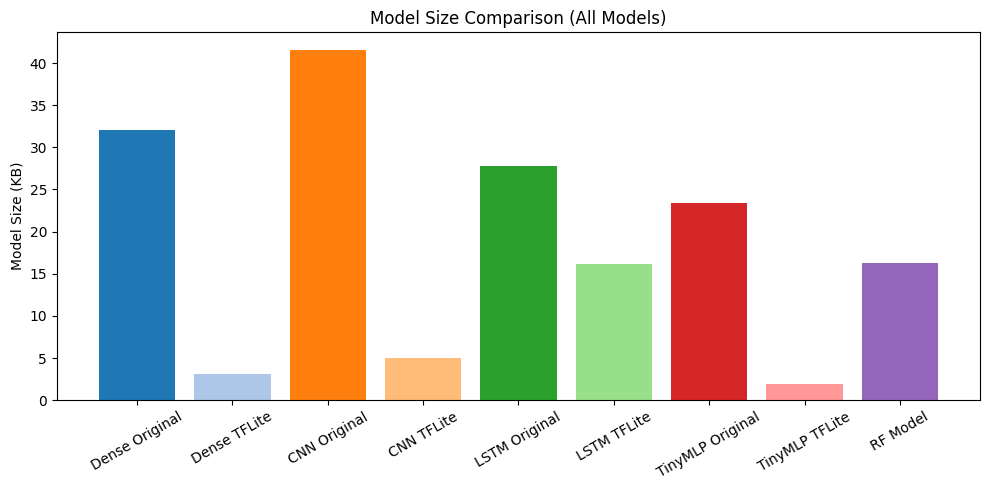

In [40]:
# Visualization: Model Size Comparison (all models)
plt.figure(figsize=(10,5))
plt.bar(results['Model'], results['Size (KB)'], color=plt.cm.tab20.colors)
plt.ylabel('Model Size (KB)')
plt.title('Model Size Comparison (All Models)')
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('Figures/model_size_comparison_all.png')
plt.show()

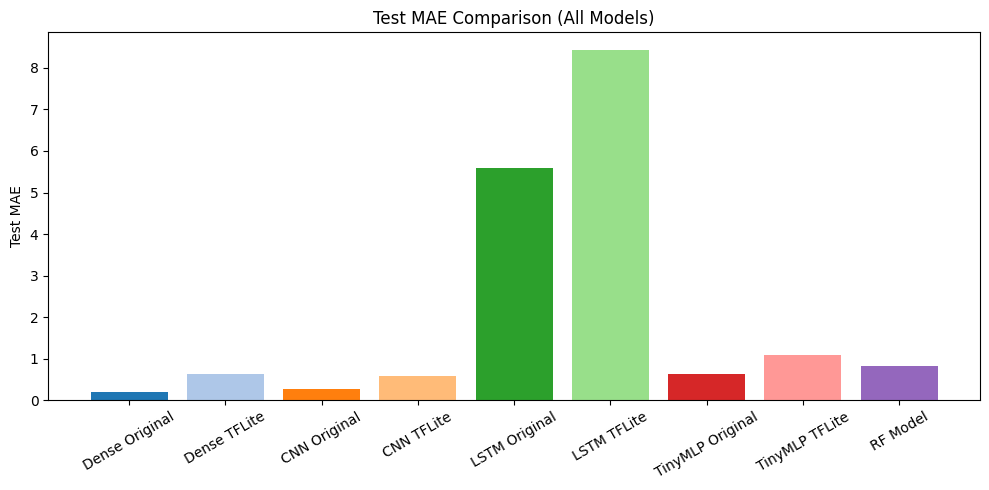

In [41]:
# Visualization: Test MAE Comparison (all models)
plt.figure(figsize=(10,5))
plt.bar(results['Model'], results['Test MAE'], color=plt.cm.tab20.colors)
plt.ylabel('Test MAE')
plt.title('Test MAE Comparison (All Models)')
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('Figures/model_mae_comparison_all.png')
plt.show()

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


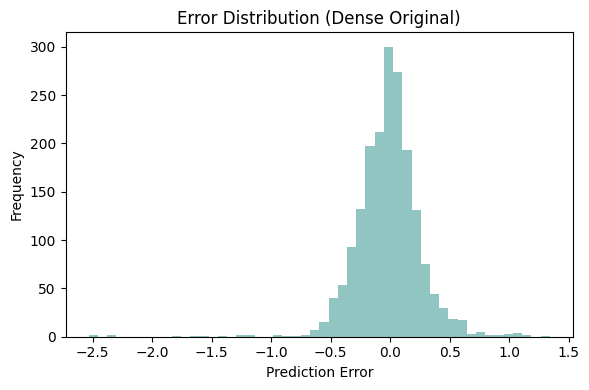

In [44]:
# Visualization: Error Distribution for Best Model (lowest MAE)
best_idx = results['Test MAE'].idxmin()
best_model_name = results.iloc[best_idx]['Model']

if 'TFLite' in best_model_name:
    # TFLite model
    tflite_path = f"Models/{best_model_name.lower().replace(' ', '_')}.tflite"
    preds = []
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    for i in range(len(X_test)):
        x = X_test[i:i+1].astype(np.float32)
        scale, zero_point = input_details[0]['quantization']
        x_q = (x / scale + zero_point).astype(np.int8)
        interpreter.set_tensor(input_details[0]['index'], x_q)
        interpreter.invoke()
        y_q = interpreter.get_tensor(output_details[0]['index'])
        y_pred = (y_q.astype(np.float32) - output_details[0]['quantization'][1]) * output_details[0]['quantization'][0]
        preds.append(y_pred[0][0])
    preds = np.array(preds)
elif 'RF' in best_model_name:
    preds = rf_model.predict(X_test)
else:
    # Keras model
    model_map = {
        'Dense Original': dense_model,
        'CNN Original': cnn_model,
        'LSTM Original': lstm_model,
        'TinyMLP Original': tinymlp_model
    }
    preds = model_map[best_model_name].predict(X_test).flatten()

plt.figure(figsize=(6,4))
plt.hist(preds - y_test, bins=50, color='#76b7b2', alpha=0.8)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title(f'Error Distribution ({best_model_name})')
plt.tight_layout()
plt.savefig(f'Figures/{best_model_name.lower().replace(" ", "_")}_error_distribution.png')
plt.show()

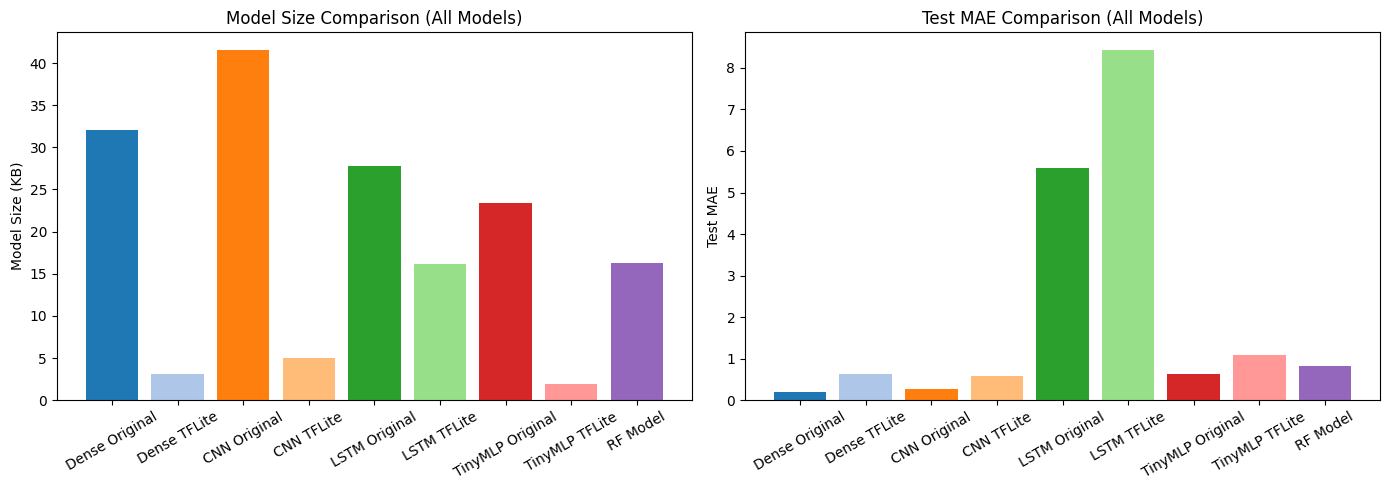

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


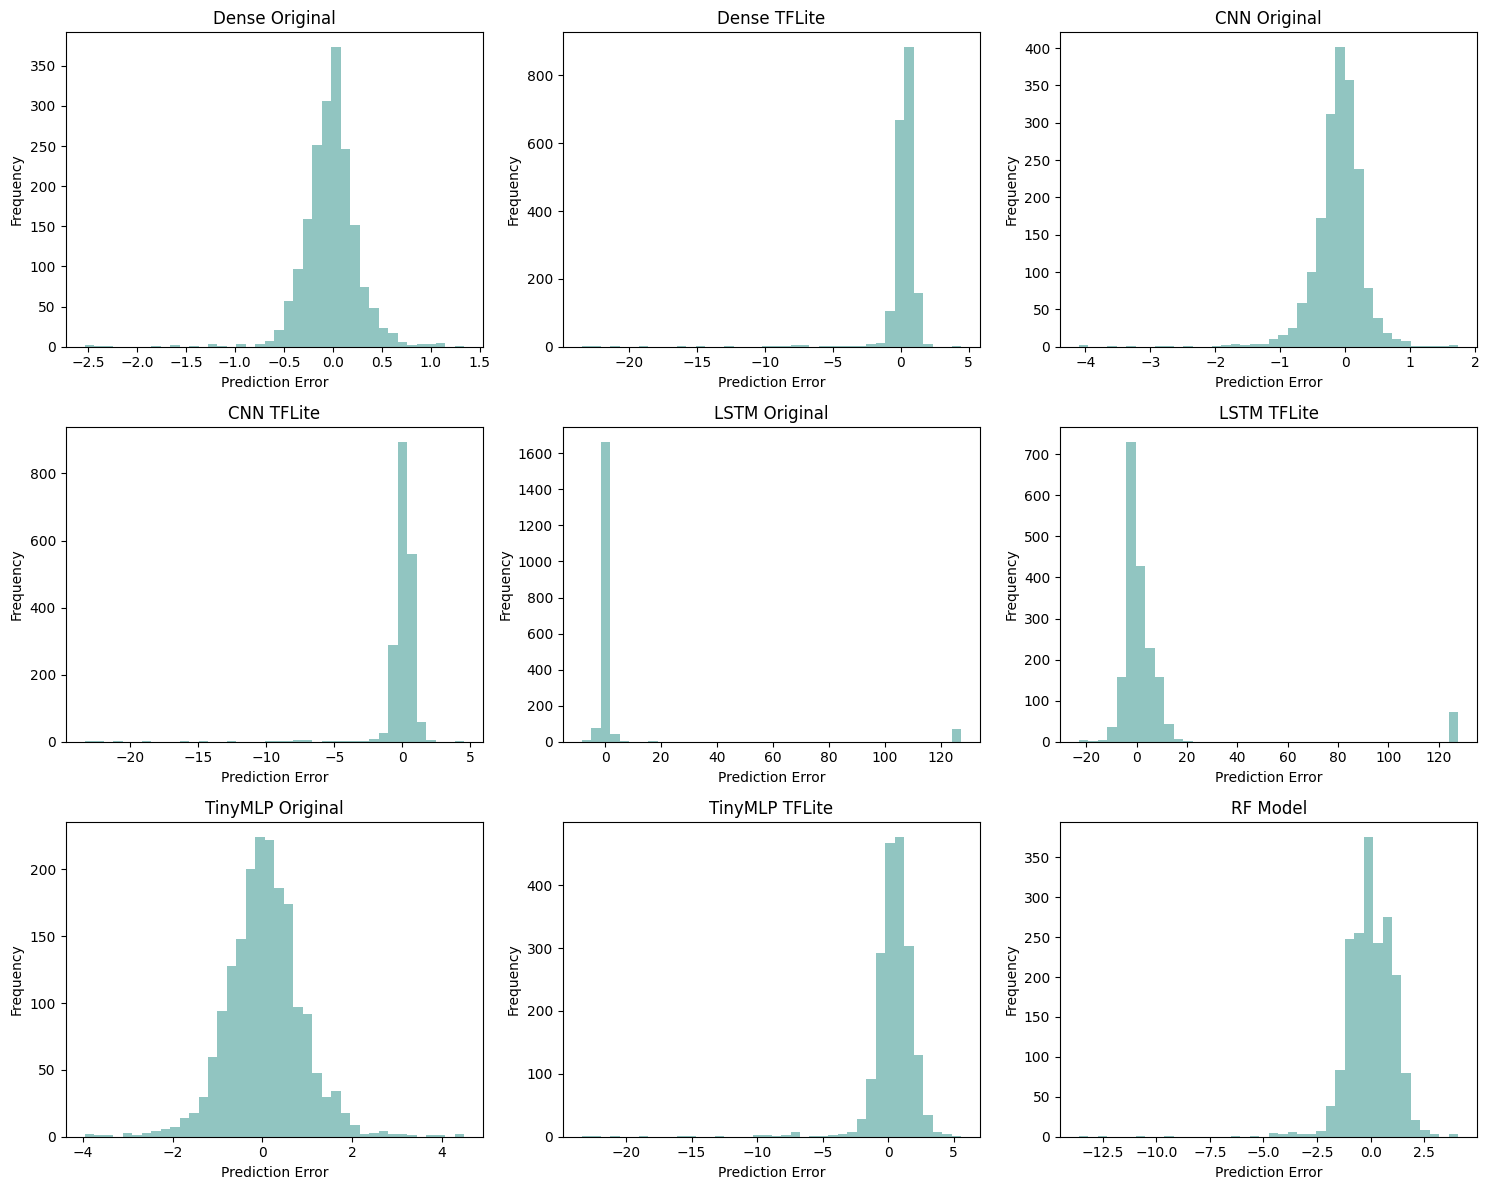

In [46]:
def evaluate_tflite_model_flexible(tflite_path, X_test, y_test, return_preds=False):
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    input_dtype = input_details[0]['dtype']
    quant_params = input_details[0]['quantization']
    y_preds = []
    for i in range(len(X_test)):
        x = X_test[i:i+1].astype(np.float32)
        if input_dtype == np.int8:
            scale, zero_point = quant_params
            x_in = (x / scale + zero_point).astype(np.int8)
        else:
            x_in = x.astype(np.float32)
        interpreter.set_tensor(input_details[0]['index'], x_in)
        interpreter.invoke()
        y_q = interpreter.get_tensor(output_details[0]['index'])
        # Dequantize if needed
        if output_details[0]['dtype'] == np.int8:
            y_pred = (y_q.astype(np.float32) - output_details[0]['quantization'][1]) * output_details[0]['quantization'][0]
            y_preds.append(y_pred[0][0])
        else:
            y_preds.append(y_q[0][0])
    y_preds = np.array(y_preds)
    if return_preds:
        return y_preds
    mae = np.mean(np.abs(y_preds - y_test))
    return mae

# Visualization: Model Size and MAE Comparison (all models) in a grid
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Model Size
axs[0].bar(results['Model'], results['Size (KB)'], color=plt.cm.tab20.colors)
axs[0].set_ylabel('Model Size (KB)')
axs[0].set_title('Model Size Comparison (All Models)')
axs[0].tick_params(axis='x', rotation=30)

# Test MAE
axs[1].bar(results['Model'], results['Test MAE'], color=plt.cm.tab20.colors)
axs[1].set_ylabel('Test MAE')
axs[1].set_title('Test MAE Comparison (All Models)')
axs[1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.savefig('Figures/model_size_mae_comparison_grid.png')
plt.show()

# Error Distribution for all models in a grid
model_pred_funcs = {
    'Dense Original': lambda: dense_model.predict(X_test).flatten(),
    'Dense TFLite': lambda: evaluate_tflite_model_flexible('Models/dense_model_quant.tflite', X_test, y_test, return_preds=True),
    'CNN Original': lambda: cnn_model.predict(X_test).flatten(),
    'CNN TFLite': lambda: evaluate_tflite_model_flexible('Models/cnn_model_quant.tflite', X_test, y_test, return_preds=True),
    'LSTM Original': lambda: lstm_model.predict(X_test).flatten(),
    'LSTM TFLite': lambda: evaluate_tflite_model_flexible('Models/lstm_model_quant.tflite', X_test, y_test, return_preds=True),
    'TinyMLP Original': lambda: tinymlp_model.predict(X_test).flatten(),
    'TinyMLP TFLite': lambda: evaluate_tflite_model_flexible('Models/tinymlp_model_quant.tflite', X_test, y_test, return_preds=True),
    'RF Model': lambda: rf_model.predict(X_test)
}

# Plot error distributions for all models in a grid
n_models = len(results)
ncols = 3
nrows = int(np.ceil(n_models / ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4))
axs = axs.flatten()

for idx, row in results.iterrows():
    model_name = row['Model']
    preds = model_pred_funcs[model_name]()
    axs[idx].hist(preds - y_test, bins=40, color='#76b7b2', alpha=0.8)
    axs[idx].set_title(model_name)
    axs[idx].set_xlabel('Prediction Error')
    axs[idx].set_ylabel('Frequency')

# Hide any unused subplots
for i in range(len(results), len(axs)):
    axs[i].axis('off')

plt.tight_layout()
plt.savefig('Figures/all_models_error_distributions_grid.png')
plt.show()

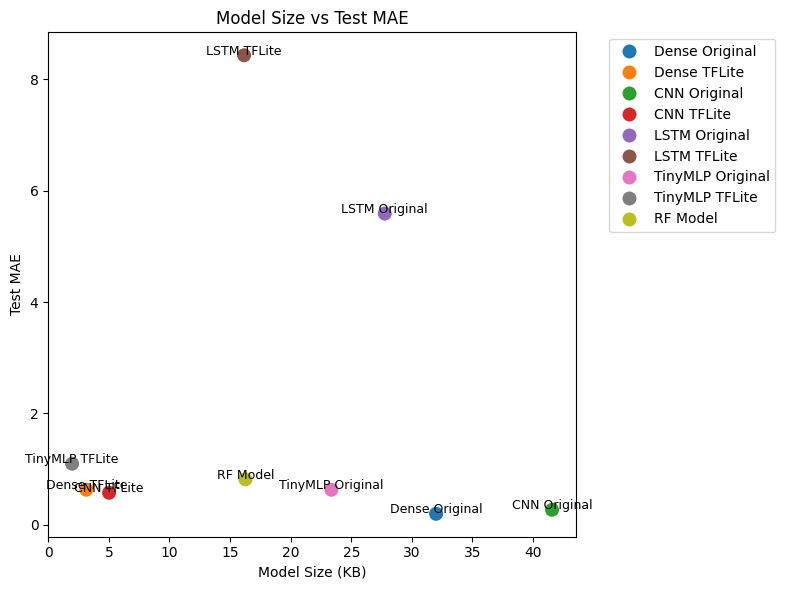

C:\Users\ROG\AppData\Local\Temp\ipykernel_28652\2666552677.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sorted_results, x='Model', y='Test MAE', palette='viridis')


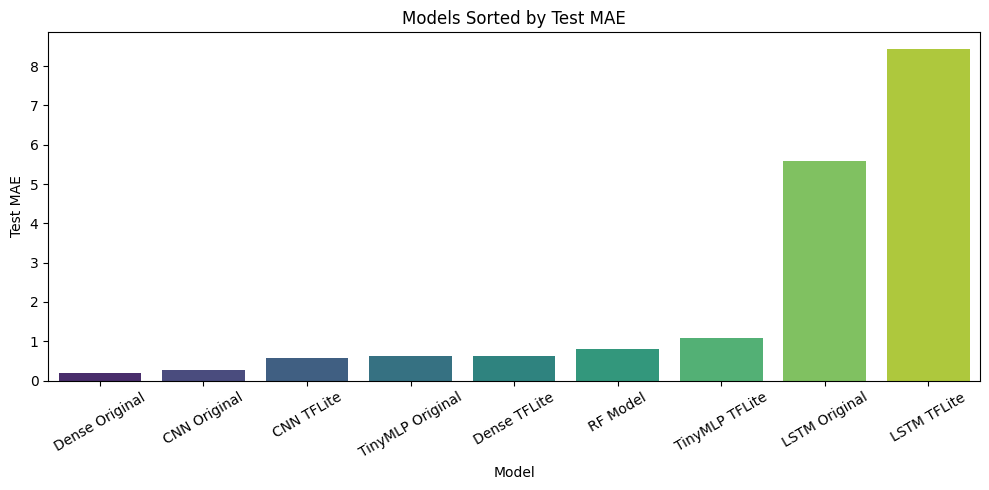

C:\Users\ROG\AppData\Local\Temp\ipykernel_28652\2666552677.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sorted_size, x='Model', y='Size (KB)', palette='mako')


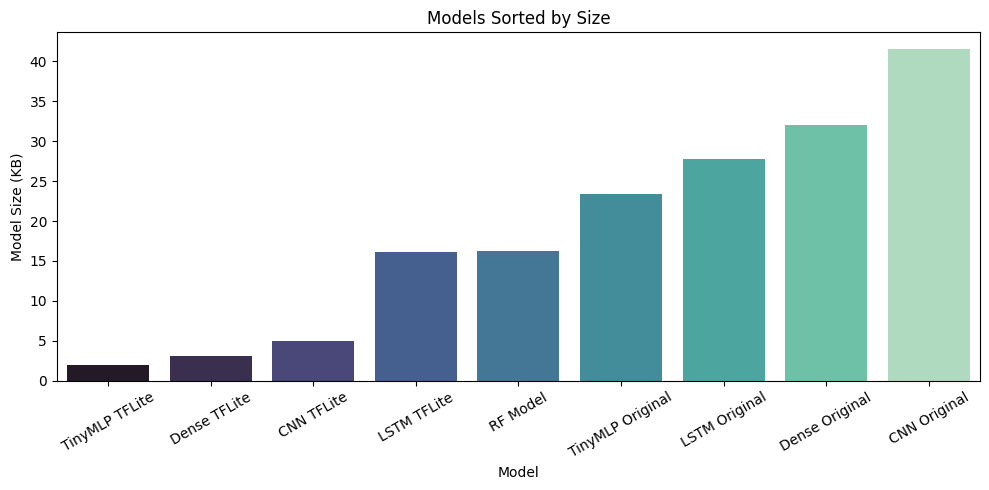

C:\Users\ROG\AppData\Local\Temp\ipykernel_28652\2666552677.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results, x='Model', y='MAE per KB', palette='rocket')


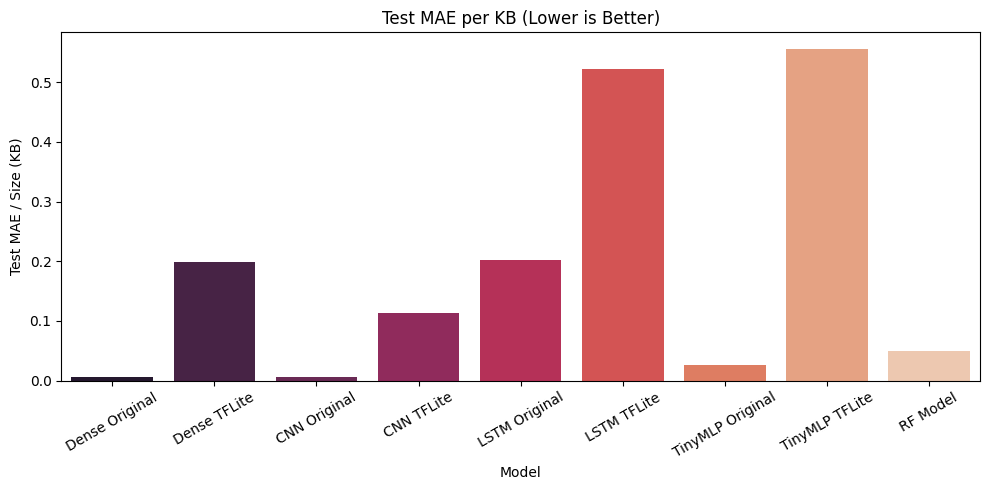

In [ ]:
# Additional Visualizations for All Models

import seaborn as sns

# 1. Scatter plot: Model Size vs Test MAE
plt.figure(figsize=(8,6))
sns.scatterplot(data=results, x='Size (KB)', y='Test MAE', hue='Model', s=120, palette='tab10')
for i, row in results.iterrows():
    plt.text(row['Size (KB)'], row['Test MAE']+0.01, row['Model'], fontsize=9, ha='center')
plt.title('Model Size vs Test MAE')
plt.xlabel('Model Size (KB)')
plt.ylabel('Test MAE')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('Figures/model_size_vs_mae_scatter.png')
plt.show()

# 2. Bar plot: Sorted by Test MAE (Best to Worst)
sorted_results = results.sort_values('Test MAE')
plt.figure(figsize=(10,5))
sns.barplot(data=sorted_results, x='Model', y='Test MAE', palette='viridis')
plt.title('Models Sorted by Test MAE')
plt.ylabel('Test MAE')
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('Figures/models_sorted_by_mae.png')
plt.show()

# 3. Bar plot: Sorted by Model Size (Smallest to Largest)
sorted_size = results.sort_values('Size (KB)')
plt.figure(figsize=(10,5))
sns.barplot(data=sorted_size, x='Model', y='Size (KB)', palette='mako')
plt.title('Models Sorted by Size')
plt.ylabel('Model Size (KB)')
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('Figures/models_sorted_by_size.png')
plt.show()

# 4. Ratio plot: Test MAE per KB (Efficiency)
results['MAE per KB'] = (results['Test MAE'] / results['Size (KB)']).round(3)
plt.figure(figsize=(10,5))
sns.barplot(data=results, x='Model', y='MAE per KB', palette='rocket')
plt.title('Test MAE per KB (Lower is Better)')
plt.ylabel('Test MAE / Size (KB)')
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('Figures/models_mae_per_kb.png')
plt.show()